# 1. Imports & Setup

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Import Data

In [3]:
# Load processed data
sentiment_df = pd.read_csv('./Processed Data/sentiment_reviews_18oct.csv')
print(sentiment_df.head())
#print rows
print(sentiment_df.shape)

   reviewid           playerid   gameid  \
0    639544  76561198028706627   393380   
1    639547  76561198272817436      730   
2    639571  76561198111259840  1476680   
3    639583  76561198164012532   244210   
4    639671  76561198979874677   739630   

                                              review  helpful  funny  awards  \
0  ---{ Graphics }---☐ You forget what reality is...        0      0       0   
1                    ONE OF THE GAMES I COME BACK TO        2      0       0   
2  I love this game!Of course it is currently in ...        5      0       1   
3  only purchase if using a sim wheel setup with ...        0      0       0   
4  Fun game and the community is great ive made t...        2      0       0   

       posted language  sentiment_score  
0  2025-01-03       en         5.000000  
1  2020-01-23       en         3.049362  
2  2022-09-23       en         4.779496  
3  2021-09-17       en         4.823064  
4  2020-11-27       en         5.000000  
(303871,

# 2. Sanity Check

## Duplicate Check

Initial check confirmed that there are no duplicate reviews, meaning no single player submitted more than one review for the same game.


In [4]:
# Count the number of reviews per player for each game
review_counts = sentiment_df.groupby(['playerid', 'gameid']).size().reset_index(name='num_reviews')

# Filter to find instances where a player has more than one review (duplicates)
multiple_reviews = review_counts[review_counts['num_reviews'] > 1]

if multiple_reviews.empty:
    print("No instances found where a player gave multiple reviews for the same game.")
else:
    print(multiple_reviews)

No instances found where a player gave multiple reviews for the same game.


## Plotting of sentiment distribution

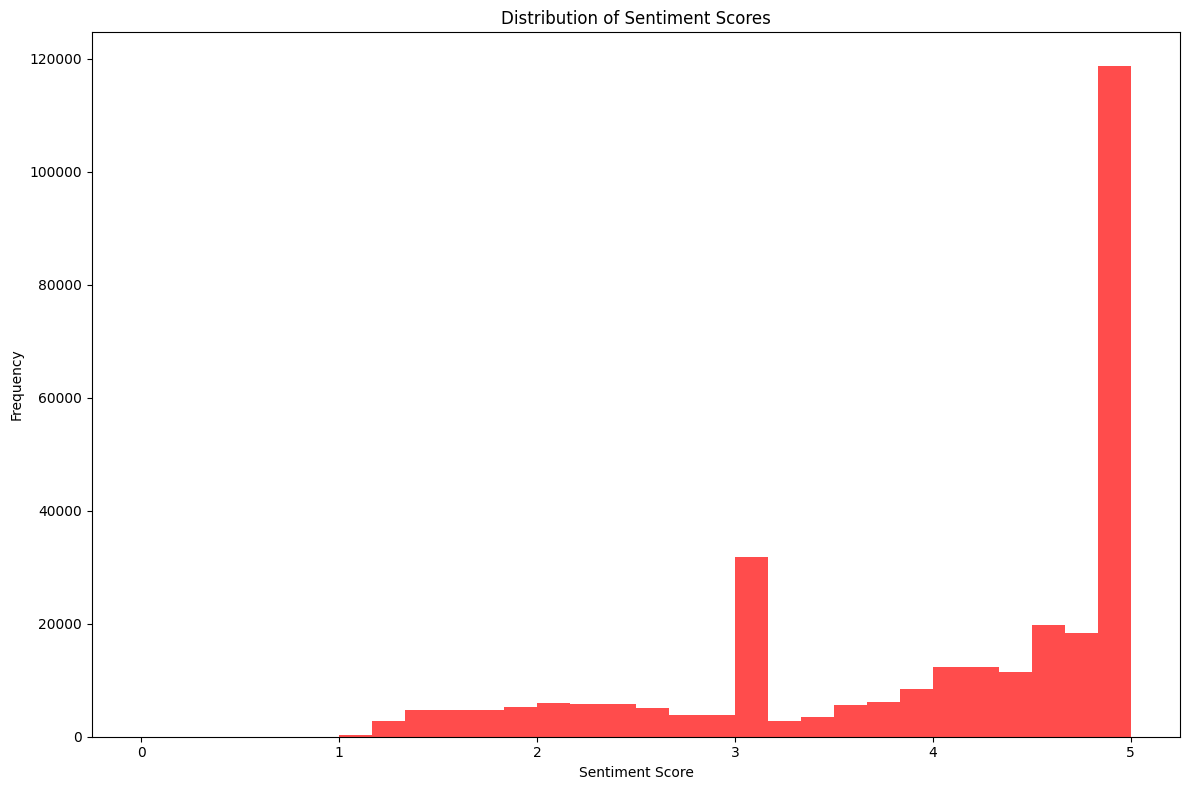

In [5]:
#visualise plot for sentiment_score
plt.figure(figsize=(12, 8))
plt.hist(sentiment_df['sentiment_score'], bins=30, color='red', alpha=0.7)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [6]:
#drop NA sentiment scores
sentiment_df = sentiment_df.dropna(subset=['sentiment_score'])
#Clip sentiment scores to be within 1.0 to 5.0 then range from 0 to 1
sentiment_df["sentiment_score"] = sentiment_df["sentiment_score"].clip(1.0, 5.0)
sentiment_df["sentiment_score_01"]   = (sentiment_df["sentiment_score"] - 1.0) / 4.0


# 3. Data Preprocessing

Using LabelEncoder to encode userId and gameId and Splitting Data into Train and Test Sets

In [7]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
sentiment_df['player'] = user_encoder.fit_transform(sentiment_df['playerid'])
sentiment_df['game'] = item_encoder.fit_transform(sentiment_df['gameid'])


## Dataset Sparsity () counts-only
U,I = sentiment_df['player'].nunique(), sentiment_df['game'].nunique()
N = len(sentiment_df)
sparsity = 1 - (N / (U * I))


def find_col(df, options):
    for col in df.columns:
        if col in options: return col
    raise ValueError("cannot find column")

#split dataset
train_df, test_df = train_test_split(sentiment_df, test_size=0.2, random_state=4222)


print(f"Players (U): {U}")
print(f"Games (I): {I}")
print(f"Interactions (N): {N}")
print(f"Data Sparsity: {sparsity*100:.2f}%")


Players (U): 65657
Games (I): 28234
Interactions (N): 303871
Data Sparsity: 99.98%


In [8]:
print("Training set length:", len(train_df))
print("Testing set length:", len(test_df))
num_players = sentiment_df['playerid'].nunique()
num_games = sentiment_df['gameid'].nunique()


Training set length: 243096
Testing set length: 60775


In [18]:
class NCFModel(nn.Module):
    def __init__(self, num_players, num_games, embedding_dim=32):
        super(NCFModel, self).__init__()
        self.player_embedding = nn.Embedding(num_players, embedding_dim)
        self.game_embedding = nn.Embedding(num_games, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 256)  
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(64, 1)


    def forward(self, player, game):
        player_emb = self.player_embedding(player)
        game_emb = self.game_embedding(game)
        x = torch.cat([player_emb, game_emb], dim=-1)
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        logits = self.output_layer(x)
        return logits


In [24]:

class NCFModel(nn.Module):
    def __init__(self, num_players, num_games, embedding_dim=32, dropout_rate=0.3):
        super(NCFModel, self).__init__()
        
        # --- Embedding Layers ---
        self.player_embedding = nn.Embedding(num_players, embedding_dim)
        self.game_embedding = nn.Embedding(num_games, embedding_dim)
        

        
        # Layer 1
        self.fc1 = nn.Linear(embedding_dim * 2, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Layer 2 (The new layer)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3 (Was your old fc2)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # --- Output Layer ---
        self.output_layer = nn.Linear(64, 1)
        
        # --- Custom Weight Initialization (Tweak) ---
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Custom function to initialize weights.
        This is a common tweak for better convergence.
        """
        if isinstance(module, nn.Embedding):
            # Initialize embeddings with a small-variance normal distribution
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.Linear):
            # Use Kaiming He initialization for layers followed by ReLU
            nn.init.kaiming_normal_(module.weight.data, a=0.01)
            if module.bias is not None:
                # Initialize biases to zero
                nn.init.constant_(module.bias.data, 0)

    def forward(self, player, game):
        # Embeddings
        player_emb = self.player_embedding(player)
        game_emb = self.game_embedding(game)
        
        # Concatenate embeddings
        x = torch.cat([player_emb, game_emb], dim=-1)
        
        # Pass through MLP tower
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x) # Apply BatchNorm *before* activation
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Layer 2 (New)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        # Output
        logits = self.output_layer(x)
        
        return logits
        
      

In [19]:
class SteamDatasetNonBinary(Dataset):
    def __init__(self, dataframe):
        # Convert columns to tensors
        self.users = torch.tensor(dataframe["player"].values, dtype=torch.long)
        self.items = torch.tensor(dataframe["game"].values, dtype=torch.long)
        #utilised 1to5 sentiment labels
        self.labels = torch.tensor(dataframe["sentiment_score_01"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


train_dataset = SteamDatasetNonBinary(train_df)
test_dataset = SteamDatasetNonBinary(test_df)
train_loader_nonbinary = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_nonbinary = DataLoader(test_dataset, batch_size=128, shuffle=False)



Epoch 1 | Train Loss: 0.23557 | Val Loss: 0.08413 | RMSE: 0.29004 | NDCG@10: 0.97598 | MAE: 0.25690
Epoch 2 | Train Loss: 0.07871 | Val Loss: 0.07541 | RMSE: 0.27461 | NDCG@10: 0.97668 | MAE: 0.23904
Epoch 3 | Train Loss: 0.06989 | Val Loss: 0.07219 | RMSE: 0.26868 | NDCG@10: 0.97779 | MAE: 0.22362
Epoch 4 | Train Loss: 0.06168 | Val Loss: 0.07337 | RMSE: 0.27086 | NDCG@10: 0.97754 | MAE: 0.22134
Epoch 5 | Train Loss: 0.05454 | Val Loss: 0.07566 | RMSE: 0.27507 | NDCG@10: 0.97739 | MAE: 0.22038
Epoch 6 | Train Loss: 0.04739 | Val Loss: 0.07851 | RMSE: 0.28019 | NDCG@10: 0.97686 | MAE: 0.21992
Epoch 7 | Train Loss: 0.03573 | Val Loss: 0.08383 | RMSE: 0.28954 | NDCG@10: 0.97713 | MAE: 0.21917
Epoch 8 | Train Loss: 0.03303 | Val Loss: 0.08351 | RMSE: 0.28897 | NDCG@10: 0.97709 | MAE: 0.21942
Epoch 9 | Train Loss: 0.03109 | Val Loss: 0.08433 | RMSE: 0.29040 | NDCG@10: 0.97706 | MAE: 0.22182
Epoch 10 | Train Loss: 0.02904 | Val Loss: 0.08411 | RMSE: 0.29001 | NDCG@10: 0.97713 | MAE: 0.21791

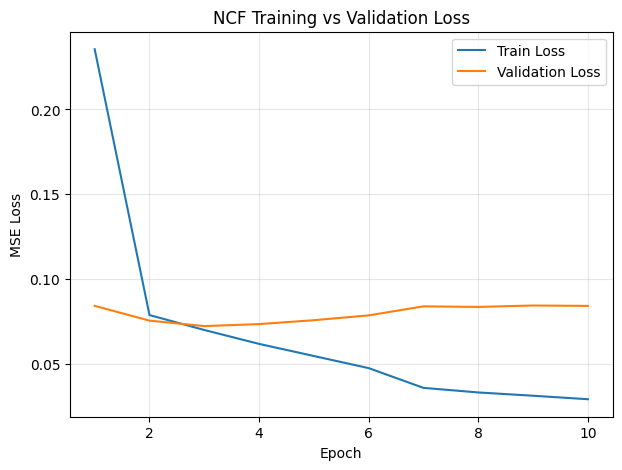

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

model = NCFModel(num_players, num_games, embedding_dim=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimiser = optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=2)
EPOCHS = 10

def evaluation_metrics(model, loader, device):
    model.eval()
    all_preds, all_labels, all_users = [], [], []
    total_val_loss, val_batches = 0.0, 0
    with torch.no_grad():
        for users, items, labels in loader:
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)

            preds = model(users, items).squeeze(1)
            loss = criterion(preds, labels)
            total_val_loss += loss.item()
            val_batches += 1

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_users.append(users.cpu().numpy())

    preds = np.concatenate(all_preds)
    labels = np.concatenate(all_labels)
    users = np.concatenate(all_users)

    rmse = np.sqrt(np.mean((preds - labels) ** 2))


    ndcgs = []
    user_to_idx = {}
    for i, u in enumerate(users):
        if int(u) not in user_to_idx:
            user_to_idx[int(u)] = []
        user_to_idx[int(u)].append(i)

    for u, idxs in user_to_idx.items():
        scores_u = preds[idxs]
        labels_u = labels[idxs]
        order = np.argsort(-scores_u)  
        ranked_relevances = labels_u[order]
        ndcgs.append(ndcg_at_k(ranked_relevances, 10))

    ndcg10 = float(np.mean(ndcgs)) if len(ndcgs) > 0 else 0.0

    # Mean Absolute Error
    mae = np.mean(np.abs(preds - labels))

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    return avg_val_loss, rmse, ndcg10, mae


train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_train_loss, train_batches = 0.0, 0

    for users, items, labels in train_loader_nonbinary:
        users = users.to(device)
        items = items.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()
        preds = model(users, items).squeeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimiser.step()

        running_train_loss += loss.item()
        train_batches += 1

    avg_train_loss = running_train_loss / max(train_batches, 1)
    train_losses.append(avg_train_loss)

    #eval
    val_loss, rmse, ndcg10, mae = evaluation_metrics(model, test_loader_nonbinary, device)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch} | "
          f"Train Loss: {avg_train_loss:.5f} | "
          f"Val Loss: {val_loss:.5f} | "
          f"RMSE: {rmse:.5f} | "
          f"NDCG@10: {ndcg10:.5f} | "
          f"MAE: {mae:.5f}")

plt.figure(figsize=(7,5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.title("NCF Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


